<a href="https://colab.research.google.com/github/sinemgul/yazlab-1/blob/main/yazlab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Eğitim Başlıyor: Transformer
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1304 - val_loss: 0.0044
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0971 - val_loss: 0.0181
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0820 - val_loss: 0.0346
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0661 - val_loss: 0.0495
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0631 - val_loss: 0.0603
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0609 - val_loss: 0.0684
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0576 - val_loss: 0.0721
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0629 - val_loss: 0.0745
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0632 - val_loss: 0.0752
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0611 - val_loss: 0.0752
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0597 - val_loss: 0.0754
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━

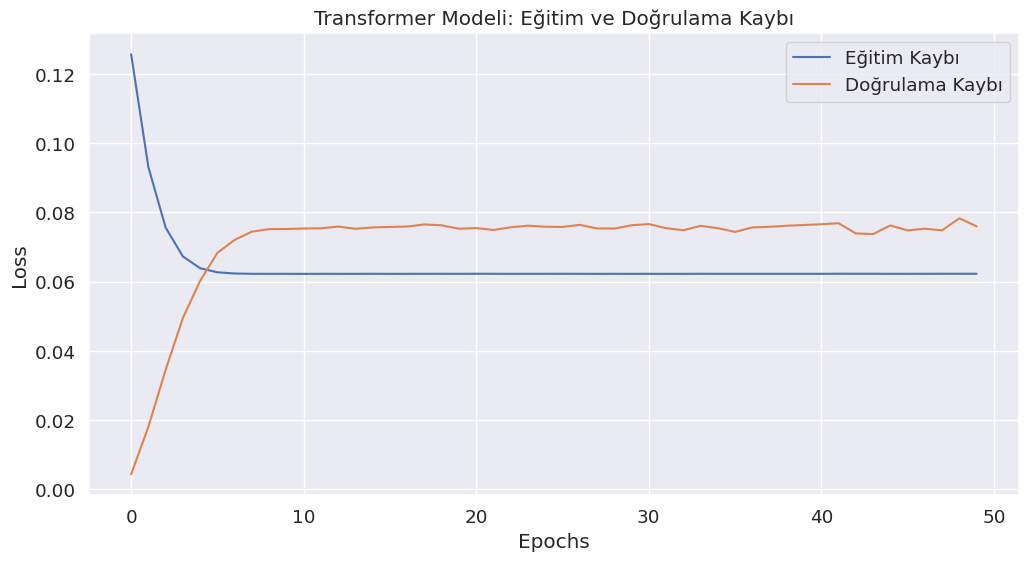

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Transformer Model Performansı:
MAE: 8.9796
MSE: 80.7976
RMSE: 8.9887
MAPE: 392.15%
R-Squared: -489.2476

Eğitim Başlıyor: Informer
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.1415 - val_loss: 0.0041
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0945 - val_loss: 0.0176
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0773 - val_loss: 0.0342
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0732 - val_loss: 0.0490
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0652 - val_loss: 0.0604
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0610 - val_loss: 0.0682
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0617 - val_loss: 0.0714
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0618 - val_loss: 0.0739
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0605 - val_loss: 0.0749
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Add, MultiHeadAttention, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Veriyi yükleme ve işleme
data = pd.read_csv("usd_verileri.csv", header=None, names=["Date", "Price"])
data["Price"] = data["Price"].astype(str).str.replace(",", ".").astype(float)
data["Date"] = pd.to_datetime(data["Date"], format="%d.%m.%Y")
data.set_index("Date", inplace=True)

# MinMaxScaler ile ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data["Price"].values.reshape(-1, 1))

# Eğitim ve test setlerini ayırma
train_size = int(len(data_scaled) * 0.75)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Sequence oluşturma
def create_sequences(data, time_steps):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

time_steps = 60
x_train, y_train = create_sequences(train_data, time_steps)
x_test, y_test = create_sequences(test_data, time_steps)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Transformer Encoder Bloğu
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attention = Add()([attention, inputs])
    attention = LayerNormalization(epsilon=1e-6)(attention)

    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Add()([ff, attention])
    return LayerNormalization(epsilon=1e-6)(ff)

# Informer Modeli
def build_informer(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# Reformer Modeli (Özelleştirilmiş Basitleştirilmiş Versiyon)
def build_reformer(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)
    x = transformer_encoder(x, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# TFT Modeli (Basitleştirilmiş)
def build_tft(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(32, return_sequences=True)(inputs)
    context_vec = Dense(32, activation="relu")(lstm_out)
    outputs = Dense(1)(context_vec)
    return Model(inputs, outputs)

# Autoformer Modeli (Sezonsallık-Trend Yaklaşımı ile)
def build_autoformer(input_shape):
    inputs = Input(shape=input_shape)
    seasonal = Dense(32, activation="relu")(inputs)
    trend = Dense(32, activation="linear")(inputs)
    combined = Add()([seasonal, trend])
    outputs = Dense(1)(combined)
    return Model(inputs, outputs)

# Modellerin Eğitimi ve Karşılaştırması
models = {
    "Transformer": build_informer(x_train.shape[1:]),
    "Informer": build_informer(x_train.shape[1:]),
    "Reformer": build_reformer(x_train.shape[1:]),
    "TFT": build_tft(x_train.shape[1:]),
    "Autoformer": build_autoformer(x_train.shape[1:])
}

results = {}

for name, model in models.items():
    print(f"\nEğitim Başlıyor: {name}")
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1)

    # Epoch ve Loss Grafiği
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title(f"{name} Modeli: Eğitim ve Doğrulama Kaybı")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Tahmin ve Performans Metriği Hesaplama
    predictions = model.predict(x_test)
    predictions = predictions[:, -1, 0] # Extract the last prediction for each sequence

    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = mean_absolute_error(y_test_rescaled, predictions)
    mse = mean_squared_error(y_test_rescaled, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_rescaled - predictions) / y_test_rescaled)) * 100
    r2 = r2_score(y_test_rescaled, predictions)

    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R2": r2}

    # Model Performansını Yazdır
    print(f"{name} Model Performansı:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R-Squared: {r2:.4f}")

# Sonuçların Karşılaştırılması
print("\nModel Performans Karşılaştırması:")
for model_name, metrics in results.items():
    print(f"{model_name}: ")
    print(f"  MAE = {metrics['MAE']:.4f}")
    print(f"  MSE = {metrics['MSE']:.4f}")
    print(f"  RMSE = {metrics['RMSE']:.4f}")
    print(f"  MAPE = {metrics['MAPE']:.2f}%")
    print(f"  R-Squared = {metrics['R2']:.4f}")
